# Volume limited merger fraction with Galaxy Zoo 1 and Galaxy Zoo 2

In this notebook we use Galaxy Zoo 1 (GZ1) and Galaxy Zoo 2 (GZ2) data which has been matched to group data from Yang, calculating merger fractions for group size, stellar mass, halo mass, galaxy velocities and group velocity dispersion.

For this notebook we volume limit our sample of galaxies, keeping the original group size of the non-volume limited group.

The GZ1 and GZ2 data can be found at https://data.galaxyzoo.org/
<br>
Information on Data Release 7 (DR7) of the Sloan Digital Sky Survery (SDSS) can be found at https://classic.sdss.org/dr7/
<br>
The Yang group data can be found at https://gax.sjtu.edu.cn/data/Group.html

#### Data
There are 4 different data sets we are using from the GZ data page. For GZ1 we are using "Table 2", which are galaxies from the entire GZ1 data set with spectra available in SDSS DR7 and "Table 3", which are galaxies from the entire GZ1 data set with no spectra available in SDSS DR7. These have 667,944 and 225,268 galaxies in them respectively.
<br>
For GZ1 we are using "Table 5", which are galaxies from the main GZ2 sample spectroscopic redshifts available in SDSS DR7 and "Table 6", which are galaxies from the main GZ2 sample with only photometric redshifts available in SDSS DR7. These have 243,500 and 42,462 galaxies in them respectively.
<br>
We use Yang Catalogue "PetroC" containing 639,359 galaxies and 473,872 groups.

#### Matching GZ1, GZ2 and Yang
The Yang data set covers redshifts $0.01 \leq z \leq 0.2$, whereas GZ1 and GZ2 cover a greater redshift range. Hence we expect to lose some galaxies when we match the GZ1&2 data to the Yang catalogue. We match the GZ1&2 data to the Yang data by right-ascension (ra) and declination (dec) with a maximum error in position of 5 arcsec, preferentially choosing galaxies with spectra available if both a galaxy from the spectroscopic data and from the photometric data match to the same Yang galaxy.

The total number of matches in Yang for each of the 4 galaxy zoo data sets are:

- GZ1 spectroscopic: 586,594 galaxies
- GZ1 photometric: 42,197 galaxies
- GZ2 spectroscopic: 233,767 galaxies
- GZ2 photometric: 19,451 galaxies

In total there are 628,791 galaxies in Yang with GZ1 data and 253,218 galaxies in Yang with GZ2 data, with 629,365 galaxies from Yang having either GZ1 or GZ2 data and 252,644 galaxies with both GZ1 and GZ2 data.

From now on we shall refer to the Yang group data set of 639,359 galaxies as Yang, and the matched GZ1&2 and Yang data sets as GZ1 and GZ2.

### Importing the data
First we import the necessary packages and import the data into an Astropy Table "all_data".

We display the head of the table to get an idea of what the data looks like.

In [1]:
# from astropy.table import Table
from astropy.table import Table
from astropy.io import fits
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Import .fits data as a table
data_filename = "E:\\MPhys Project\\Main Data\\Group_GZ1_GZ2_full_new_best_z_and_Mr_fixed_groups.fits" # All galaxies in group data set with matched GZ1 & Gz2 galaxies

with fits.open(data_filename) as data:
    all_data = Table(data[1].data)

# Display head of data
display(all_data[0:5])

galaxy ID,NYU-VAGC ID object ID,ra_galaxy,dec_galaxy,z_galaxy,apparent magnitude r_band,magnitude limit r_band,completeness,col9 Petro,col10 Petro,col11 Model,col12 Model,redshift source type,group id,brightest galaxy,most massive galaxy,RA_group,dec_group,z_group,group L_-19.5 log L_odoth2,group stellar mass,halo mass1,halo mass2,mean separation brighter,mean separation massive,f_edge,ID1,ID2,group_size,OBJID_GZ1,RA_GZ1,DEC_GZ1,NVOTE_GZ1,P_EL,P_CW,P_ACW,P_EDGE,P_DK,P_MG,P_CS,P_EL_DEBIASED,P_CS_DEBIASED,SPIRAL,ELLIPTICAL,UNCERTAIN,U_GZ1,G_GZ1,R_GZ1,I_GZ1,Z_GZ1,UERR_GZ1,GERR_GZ1,RERR_GZ1,IERR_GZ1,ZERR_GZ1,R50_ARCSEC_GZ1,R90_ARCSEC_GZ1,REDSHIFT_GZ1,REDSHIFTERR_GZ1,REDSHIFTCONF_GZ1,MU_GZ1,MG_GZ1,MR_GZ1,MI_GZ1,MZ_GZ1,MUERR_GZ1,MGERR_GZ1,MRERR_GZ1,MIERR_GZ1,MZERR_GZ1,R50_KPC_GZ1,specobjid_GZ2,dr8objid_GZ2,dr7objid_GZ2,ra_GZ2,dec_GZ2,rastring_GZ2,decstring_GZ2,sample_GZ2,gz2class,total_classifications_GZ2,total_votes_GZ2,t01_smooth_or_features_a01_smooth_count,t01_smooth_or_features_a01_smooth_weight,t01_smooth_or_features_a01_smooth_fraction,t01_smooth_or_features_a01_smooth_weighted_fraction,t01_smooth_or_features_a01_smooth_debiased,t01_smooth_or_features_a01_smooth_flag,t01_smooth_or_features_a02_features_or_disk_count,t01_smooth_or_features_a02_features_or_disk_weight,t01_smooth_or_features_a02_features_or_disk_fraction,t01_smooth_or_features_a02_features_or_disk_weighted_fraction,t01_smooth_or_features_a02_features_or_disk_debiased,t01_smooth_or_features_a02_features_or_disk_flag,t01_smooth_or_features_a03_star_or_artifact_count,t01_smooth_or_features_a03_star_or_artifact_weight,t01_smooth_or_features_a03_star_or_artifact_fraction,t01_smooth_or_features_a03_star_or_artifact_weighted_fraction,t01_smooth_or_features_a03_star_or_artifact_debiased,t01_smooth_or_features_a03_star_or_artifact_flag,t02_edgeon_a04_yes_count,t02_edgeon_a04_yes_weight,t02_edgeon_a04_yes_fraction,t02_edgeon_a04_yes_weighted_fraction,t02_edgeon_a04_yes_debiased,t02_edgeon_a04_yes_flag,t02_edgeon_a05_no_count,t02_edgeon_a05_no_weight,t02_edgeon_a05_no_fraction,t02_edgeon_a05_no_weighted_fraction,t02_edgeon_a05_no_debiased,t02_edgeon_a05_no_flag,t03_bar_a06_bar_count,t03_bar_a06_bar_weight,t03_bar_a06_bar_fraction,t03_bar_a06_bar_weighted_fraction,t03_bar_a06_bar_debiased,t03_bar_a06_bar_flag,t03_bar_a07_no_bar_count,t03_bar_a07_no_bar_weight,t03_bar_a07_no_bar_fraction,t03_bar_a07_no_bar_weighted_fraction,t03_bar_a07_no_bar_debiased,t03_bar_a07_no_bar_flag,t04_spiral_a08_spiral_count,t04_spiral_a08_spiral_weight,t04_spiral_a08_spiral_fraction,t04_spiral_a08_spiral_weighted_fraction,t04_spiral_a08_spiral_debiased,t04_spiral_a08_spiral_flag,t04_spiral_a09_no_spiral_count,t04_spiral_a09_no_spiral_weight,t04_spiral_a09_no_spiral_fraction,t04_spiral_a09_no_spiral_weighted_fraction,t04_spiral_a09_no_spiral_debiased,t04_spiral_a09_no_spiral_flag,t05_bulge_prominence_a10_no_bulge_count,t05_bulge_prominence_a10_no_bulge_weight,t05_bulge_prominence_a10_no_bulge_fraction,t05_bulge_prominence_a10_no_bulge_weighted_fraction,t05_bulge_prominence_a10_no_bulge_debiased,t05_bulge_prominence_a10_no_bulge_flag,t05_bulge_prominence_a11_just_noticeable_count,t05_bulge_prominence_a11_just_noticeable_weight,t05_bulge_prominence_a11_just_noticeable_fraction,t05_bulge_prominence_a11_just_noticeable_weighted_fraction,t05_bulge_prominence_a11_just_noticeable_debiased,t05_bulge_prominence_a11_just_noticeable_flag,t05_bulge_prominence_a12_obvious_count,t05_bulge_prominence_a12_obvious_weight,t05_bulge_prominence_a12_obvious_fraction,t05_bulge_prominence_a12_obvious_weighted_fraction,t05_bulge_prominence_a12_obvious_debiased,t05_bulge_prominence_a12_obvious_flag,t05_bulge_prominence_a13_dominant_count,t05_bulge_prominence_a13_dominant_weight,t05_bulge_prominence_a13_dominant_fraction,t05_bulge_prominence_a13_dominant_weighted_fraction,t05_bulge_prominence_a13_dominant_debiased,t05_bulge_prominence_a13_dominant_flag,t06_odd_a14_yes_count,t06_odd_a14_yes_weight,t06_odd_a14_yes_fraction,t

### Classifying mergers
Many of the galaxies in our data set have classification data from both GZ1 and GZ2. As GZ1 and GZ2 have different decision trees, we must classify mergers in a different way for each. We can then compare the classifications for galaxies which are in both sets, to see if our classification methods are consistent.

For GZ1 we will use the threshold for merger classification as described in [Darg et al. (2009)](https://arxiv.org/pdf/0903.4937.pdf):
- merger weighted vote fraction $p_m$ > 0.4

Note that this was used in Darg et al. (2009) for only galaxies with redshifts $0.005 < z < 0.1$, but we will use it for galaxies in the range $0.1 \leq z \leq 0.2$ here also.

For GZ2 we will use the threshold for merger classification we have done previously:
- "t06_odd_a14_yes_count" $\geq$ 20
- "t06_odd_a14_yes_debiased" > 0.42
- "t08_odd_feature_a24_merger_count" $\geq$ 10
- "t08_odd_feature_a24_merger_debiased" > 0.4

In [2]:
# Create a new column in the data for GZ1 mergers, with a value of 1 if the galaxy is classified as a merger, and 0 if not
all_data_pandas = all_data.to_pandas()
all_data_pandas["GZ1_merger_yes"] = 0
all_data_pandas.loc[(all_data_pandas["GZ1"] == 1) & (all_data_pandas["P_MG"] > 0.4), "GZ1_merger_yes"] = 1

# Do the same for GZ2 mergers
all_data_pandas["GZ2_merger_yes"] = 0
all_data_pandas.loc[(all_data_pandas["GZ2"] == 1) & (all_data_pandas["t06_odd_a14_yes_count"] >= 20) & (all_data_pandas["t06_odd_a14_yes_debiased"] > 0.42) & (all_data_pandas["t08_odd_feature_a24_merger_count"] >= 10) & (all_data_pandas["t08_odd_feature_a24_merger_debiased"] > 0.4), "GZ2_merger_yes"] = 1

# Return data frame
all_data = Table.from_pandas(all_data_pandas)

# Add column that gives number of merger classifications
all_data["Merger_classifications"] = all_data["GZ1_merger_yes"] + all_data["GZ2_merger_yes"]

### Volume limiting

To volume limit the sample, we need redshifts and absolute magnitudes for each of the galaxies (we are using r-band absolute magnitudes here, $M_r$). We have redshift data from Yang for all galaxies and GZ1 and GZ2 for galaxies with spectra. We have also obtained updated redshifts for galaxies that have spectroscopic redshifts available in the latest SDSS data release (DR16).

These newly obtained redshifts are be selected preferentially as the best estimate of a galaxies redshift. If a new redshift is not available, GZ2 redshifts are chosen over GZ1 redshifts as GZ2 is a more recent survey than GZ1. If neither of GZ1 or GZ2 have redshifts available, the redshift will be selected from Yang.

Now that we have obtained the best estimates of redshift for each galaxy, we will calculate the absolute magnitudes of each galaxy. This is done using the following formula:
$$ M_r = m_r - 5\log_{10}{d_L} + 5$$
where $M_r$ is the absolute magnitude, $m_r$ the apparent magnitude and $d_L$ the luminosity distance in parsecs. The luminosity distance is calculated using the Astropy package, with cosmology from [Planck 2018](https://arxiv.org/abs/1807.06209): $h = 0.6766$, $\Omega_{\Lambda} = 0.6889$ and $\Omega_\text{m} = 0.3111$. The Yang catalogue contains apparent magnitudes for each galaxy which have already been corrected for reddening and K corrected, so we can use these magnitudes as $m_r$ in the above equation.

This gives the following data for redshifts and absolute magnitudes:

Redshifts:
- If the galaxy has no spectra from GZ1 or GZ2, select redshift from Yang
- If the galaxy has a GZ1 spectra but not GZ2, select GZ1 redshift
- If the galaxy has a GZ2 spectra, select GZ2 redshift
- If the galaxy has a new obtained redshift, select this

Absolute magnitudes:
- Calculate $M_r$ using the best estimate for redshift and apparent magnitudes from Yang

This data is shown below.

In [3]:
display(all_data[["galaxy ID", "z_galaxy", "REDSHIFT_GZ1", "REDSHIFT_GZ2", "z_new", "Best_redshift_new", "MR_GZ1", "PETROMAG_MR_GZ2", "Best_Mr_new"]][0:10])

galaxy ID,z_galaxy,REDSHIFT_GZ1,REDSHIFT_GZ2,z_new,Best_redshift_new,MR_GZ1,PETROMAG_MR_GZ2,Best_Mr_new
int32,float64,float64,float32,float64,float64,float32,float32,float64
1,0.0540216,0.05401099845767021,0.054011,0.05402158,0.05402158,-21.040554,-21.041056,-21.042627630590864
2,0.0538176,0.05383089929819107,0.0538309,0.05381758,0.05381758,-20.186768,-20.186756,-20.187121165471776
3,0.0540503,0.054140400141477585,0.0541404,0.0540503,0.0540503,-21.8894,-21.8895,-21.892596003746903
4,0.1385037,--,--,-1.0,0.1385037,--,--,-21.544385642116058
5,0.1289553,0.12893100082874298,--,0.1289553,0.1289553,-21.697758,--,-21.564816141325146
6,0.1834345,0.1834769994020462,--,0.1834345,0.1834345,-22.550137,--,-22.36452724060107
7,0.139661,0.13970600068569183,--,0.139661,0.139661,-21.876328,--,-21.748439433873
8,0.1394783,0.13954100012779236,--,0.1394783,0.1394783,-21.97756,--,-21.930830479621374
9,0.1393221,0.13934199512004852,--,0.1393221,0.1393221,-21.977083,--,-21.919895553042114


Now that we have a best estimate for redshift and absolute magnitude for each galaxy, we plot a graph of redshift vs absolute magnitude (for redshifts $0.01 < z< 0.2$).

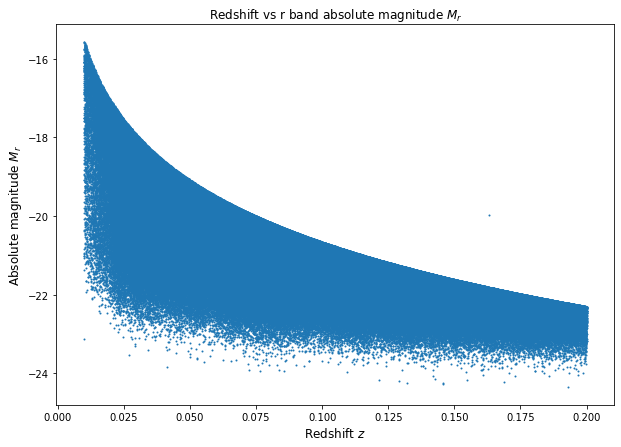

In [4]:
plt.figure(figsize=(10,7))
plt.scatter(all_data[(all_data["Best_redshift_new"] <= 0.2) & (all_data["Best_redshift_new"] >= 0.01)]["Best_redshift_new"], all_data[(all_data["Best_redshift_new"] <= 0.2) & (all_data["Best_redshift_new"] > 0.01)]["Best_Mr_new"], s=1)
plt.xlabel("Redshift $z$", fontsize=12)
plt.ylabel("Absolute magnitude $M_r$", fontsize=12)
plt.title("Redshift vs r band absolute magnitude $M_r$", fontsize=12)
plt.show()

From this plot it is clear why we would like to volume limit the sample. The apparent magnitude of a galaxy decreases with redshift, and due to SDSS having a limit below which it cannot see ($m_r > 17.77 \text{ mag}$) we are unable to see fainter galaxies at higher redshifts, we only see the brightest. For example we cannot see any $M_r = -18$ galaxies at redshift $z=0.1$ as these will have apparent magnitudes $m_r>17.77$ and cannot be detected by SDSS.

Because of this, we have a much more complete picture of galaxies at lower redshifts as we know nothing about fainter galaxies at higher redshifts. Volume limiting our sample ensures that we have a complete picture at all redshifts by placing a limit on the absolute magnitude, such that we only see the brightest galaxies at all redshifts.

We want to choose our volume limit such that we are complete at all redshifts that we are interested in, whilst maximising the number of galaxies we keep in our sample.

Here we choose the limits $M_r < -19$ and $0.01 < z < 0.05$. In order to not cut off a group near the edge of our redshift limit (i.e. if a group has members just above and just below $z=0.05$, we want to include all members not just members below $z=0.05$), we calculate the mean redshift of all galaxies in a group with $M_r < -19$ and cut the redshift instead by $0.01 < z_\text{mean} < 0.05$.

In [5]:
# # Select only galaxies with M_r < -19 and groups with more than one member
# magnitude_limited = all_data[(all_data["group_size_new"] > 1) & (all_data["Best_Mr_new"] < -19) & (all_data["Best_redshift_new"] < 0.12)]

# # Select only needed columns
# groups_data_needed = magnitude_limited[["galaxy ID", "group_id_new", "group_size_new", "Best_redshift_new"]].to_pandas()
# # Groupby galaxy group id, creating a dictrionary with group id as the key, and the indicies of the galaxies as values
# groups = groups_data_needed.groupby("group_id_new").indices

# # Add the new desired columns to the DataFrame
# groups_data_needed["z_group_mean"] = 0

# # Print the number of groups the calculation must be done for
# print("Number of groups to calculate for: " + str(len(groups)))
# i = 1

# for key, values in groups.items(): # Iterate over the dictionary of group ids
    
#     # Calculate mean redshift of group
#     groups_data_needed.loc[values, "z_group_mean"] = groups_data_needed.loc[values, "Best_redshift_new"].mean()
    
#     # Progress checker
#     if i % 5000 == 0:
#         print("Progress: " + str(i) + " groups done")
#     elif i == len(groups):
#         print("Progress: Done")
#     i += 1

In [6]:
# # Save volume limited mean group redshift data
# mean_redshift_data = Table.from_pandas(groups_data_needed[["galaxy ID", "z_group_mean"]])
# mean_redshift_data.write("mean_redshift_Mr_less_than_19.fits")

In [7]:
# all_data_pandas = all_data.to_pandas() # Pandas DataFrame of full data

# # Merge the two DataFrames, keeping all the rows in the full DataFrame
# merged = pd.merge(all_data_pandas, groups_data_needed[["galaxy ID", "z_group_mean"]],
#                   on="galaxy ID", how="left")

# # Make mean of N=1 groups equal to galaxy redshift
# merged.loc[merged["group_size_new"] == 1, "z_group_mean"] = merged.loc[merged["group_size_new"] == 1, "Best_redshift_new"]

# # Display head of data
# display(merged.head())

# # Turn DataFrame back into astropy table
# all_data = Table.from_pandas(merged)

In [8]:
# Read previously calculated mean z for volume limited groups
volume_limited_mean_z_filename = "E:\\MPhys Project\\Main Data\\mean_redshift_Mr_less_than_19.fits"

with fits.open(volume_limited_mean_z_filename) as data:
    volume_limited_mean_z = Table(data[1].data)

# Crate pandas DataFrames to merge
all_data_pandas = all_data.to_pandas()
volume_limited_mean_z_pandas = volume_limited_mean_z.to_pandas()

# Merge the two DataFrames, keeping all the rows in the full DataFrame
merged = pd.merge(all_data_pandas, volume_limited_mean_z_pandas, on="galaxy ID", how="left")

# Make mean of N=1 groups equal to galaxy redshift
merged.loc[merged["group_size_new"] == 1, "z_group_mean"] = merged.loc[merged["group_size_new"] == 1, "Best_redshift_new"]

# Display head of data
display(merged.head())

# Turn DataFrame back into astropy table
all_data = Table.from_pandas(merged)

,galaxy ID,NYU-VAGC ID object ID,ra_galaxy,dec_galaxy,z_galaxy,apparent magnitude r_band,magnitude limit r_band,completeness,col9 Petro,col10 Petro,...,Best_redshift,Best_Mr,group_id_new,group_size_new,Best_redshift_new,Best_Mr_new,GZ1_merger_yes,GZ2_merger_yes,Merger_classifications,z_group_mean
0,1,750,38.049133,0.224026,0.054022,15.939070,17.620001,0.994186,-20.207098,0.906209,...,0.054022,-21.042628,67926,1,0.054022,-21.042628,0,0,0,0.054022
1,2,751,38.352526,0.212491,0.053818,16.786047,17.620001,0.987805,-19.363531,0.820707,...,0.053818,-20.187121,23485,2,0.053818,-20.187121,0,0,0,0.053934
2,3,752,38.363598,0.210654,0.054050,15.090300,17.620001,0.987805,-20.966141,0.758547,...,0.054050,-21.892596,23485,2,0.054050,-21.892596,0,0,0,0.053934
3,4,994,54.450341,0.572606,0.138504,17.604034,17.620001,0.918367,-20.681068,0.880466,...,0.138504,-21.544386,67927,1,0.138504,-21.544386,0,0,0,0.138504
4,5,1010,54.534881,0.578615,0.128955,17.415402,17.620001,0.918367,-20.712832,0.918161,...,0.128955,-21.564816,67928,1,0.128955,-21.564816,0,0,0,0.128955


Now that we have calculate the mean group redshift for each magnitude limited group, we apply our volume limit to the data ($M_r < -19$, $0.01 < z_\text{mean} < 0.05$) and plot a redshift vs absolute magnitude graph for the volume limited sample.

Number of galaxies in volume limit: 67647
Fraction of all galaxies in volume limit: 0.1058044072266129
Number of mergers in volume limit: 2059


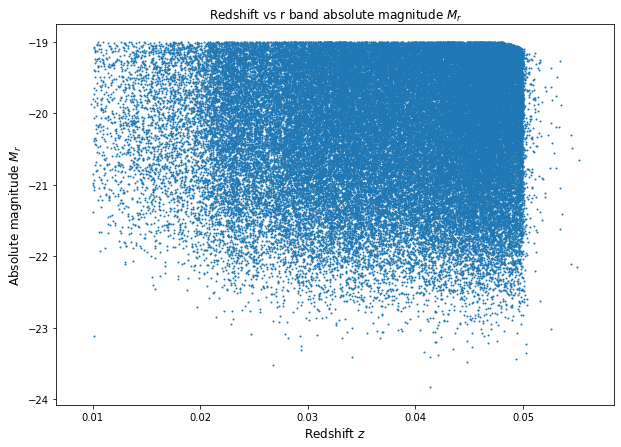

In [9]:
all_data_pandas = all_data.to_pandas()
all_data_pandas["volume_limited_sample"] = 0
all_data_pandas.loc[(all_data_pandas["Best_Mr_new"] < -19) & (all_data_pandas["z_group_mean"] < 0.05), "volume_limited_sample"] = 1
print("Number of galaxies in volume limit: " + str(sum(all_data_pandas["volume_limited_sample"])))
print("Fraction of all galaxies in volume limit: " + str(sum(all_data_pandas["volume_limited_sample"]) / len(all_data_pandas)))
print("Number of mergers in volume limit: " + str(len(all_data_pandas[(all_data_pandas["volume_limited_sample"] == 1) & (all_data_pandas["Merger_classifications"] >= 1)])))

plt.figure(figsize=(10,7))
plt.scatter(all_data_pandas[all_data_pandas["volume_limited_sample"] == 1]["Best_redshift_new"], all_data_pandas[all_data_pandas["volume_limited_sample"] == 1]["Best_Mr"], s=1)
plt.xlabel("Redshift $z$", fontsize=12)
plt.ylabel("Absolute magnitude $M_r$", fontsize=12)
plt.title("Redshift vs r band absolute magnitude $M_r$", fontsize=12)
plt.show()

This gives us a complete sample at this redshift, with 67,647 galaxies. To see the new spread of galaxies against redshift, we plot a histogram of redshift.

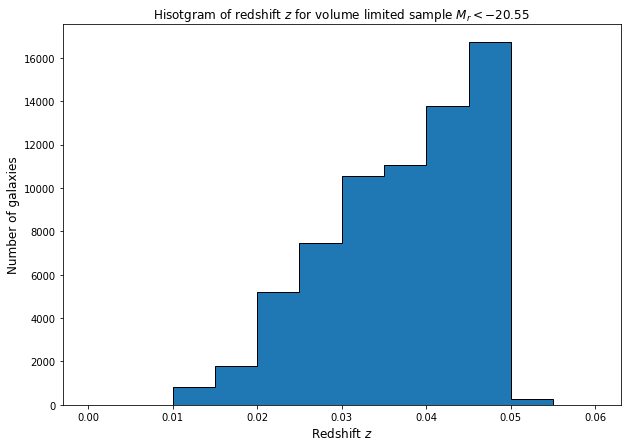

In [10]:
plt.figure(figsize=(10,7))
plt.hist(all_data_pandas[all_data_pandas["volume_limited_sample"] == 1]["Best_redshift_new"], bins=np.arange(0,0.065,0.005), edgecolor="black", histtype="stepfilled")
plt.xlabel("Redshift $z$", fontsize=12)
plt.ylabel("Number of galaxies", fontsize=12)
plt.title("Hisotgram of redshift $z$ for volume limited sample $M_r < -20.55$", fontsize=12)
plt.show()

Most galaxies are in the redshift range $ 0.03 < z < 0.05$, and the number of galaxies in each bin generally increases up to a peak at $ 0.045 < z < 0.05$ bin. This is to be expected as SDSS has a peak in the number of galaxies at $z \sim 0.08$, so we should expect the number of galaxies to increase in each bin at our low redshifts.

### Volume limited groups
Now that we have volume limited our sample, we would like to calculate the number of galaxies that are in the volume limit in each group, or the number of galaxies with $M_r < -19$ in each group. We are only interested in groups for which at least one member has either GZ1 or GZ2 data. If a group does not have any GZ data then we have no morphological information about any of its members and should not be included in the following analysis.

We add a column to our data below containing the number of galaxies in each group that are in the volume limited sample and plot a histogram of group size for groups in the volume limit and a scatter plot of the group size from the full Yang catalogue against our volume limited sample group size.

In [11]:
# Group by group id and count the number of galaxies in each group in volume limit
volume_limited_galaxies_in_group = all_data_pandas.groupby("group_id_new")["volume_limited_sample"].sum()
volume_limited_galaxies_in_group.rename("volume_limited_galaxies_in_group", inplace=True)

# Merge group size for volume limited groups with main data table
all_data_pandas = pd.merge(all_data_pandas, volume_limited_galaxies_in_group, on="group_id_new", how="left")

# Choose only galaxies in volume limit
volume_limited_groups = all_data_pandas[all_data_pandas["volume_limited_sample"] == 1].copy()

# Add column with value = 0 if the galaxy does not have GZ data, value = 1 if the galaxy does have GZ data
volume_limited_groups["GZ"] = 0
volume_limited_groups.loc[(volume_limited_groups["GZ1"] == 1) | (volume_limited_groups["GZ2"] == 1), "GZ"] = 1

# Count the number of galaxies in each group in the volume limit that have Galaxy Zoo data
volume_limited_groups_GZ_galaxies = volume_limited_groups.groupby("group_id_new")["GZ"].sum()
volume_limited_groups_GZ_galaxies.rename("GZ_galaxies_in_group", inplace=True)
volume_limited_groups_GZ_galaxies

volume_limited_groups = pd.merge(volume_limited_groups, volume_limited_groups_GZ_galaxies, on="group_id_new", how="left")

# Remove any groups from the volume limit which we have no GZ data for
volume_limited_groups = volume_limited_groups[volume_limited_groups["GZ_galaxies_in_group"] > 0].copy()

,groups,groups N=1,groups N=2,groups N=3,groups N=4,groups N=5,groups N>5
0,44418,37383,4335,1133,493,255,819


,galaxies,groups N=1,groups N=2,groups N=3,groups N=4,groups N=5,groups N>5
0,67478,37383,8670,3399,1972,1275,14779


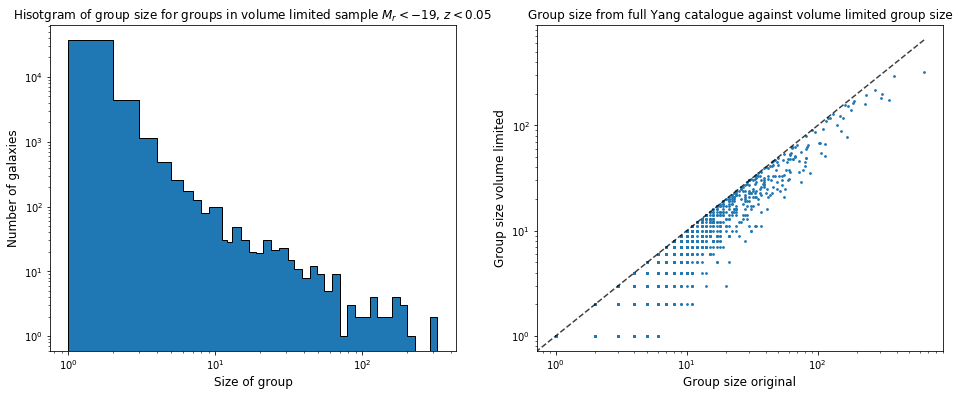

In [12]:
# Create pandas dataframes to allow us to use pandas' groupby function
volume_limited_groups_df = volume_limited_groups[["galaxy ID", "volume_limited_galaxies_in_group", "group_id_new"]].copy()
volume_limited_galaxies_df = volume_limited_groups[["volume_limited_galaxies_in_group", "galaxy ID"]].copy()

# Group data by group size, then count then unique number of groups and count the number of unique groups
volume_limited_group_counts = volume_limited_groups_df.groupby("volume_limited_galaxies_in_group")["group_id_new"].unique().apply(lambda x: len(x))
volume_limited_galaxy_counts = volume_limited_galaxies_df.groupby("volume_limited_galaxies_in_group")["galaxy ID"].unique().apply(lambda x: len(x))

# Create a dataframe and size column, easier to work with
volume_limited_group_counts = pd.DataFrame(volume_limited_group_counts)
volume_limited_group_counts.columns = ["Number of Groups"]
volume_limited_group_counts["size"] = volume_limited_group_counts.index

# Create a dataframe and size column, easier to work with
volume_limited_galaxy_counts = pd.DataFrame(volume_limited_galaxy_counts)
volume_limited_galaxy_counts.columns = ["Number of Galaxies"]
volume_limited_galaxy_counts["size"] = volume_limited_galaxy_counts.index

# Create a new dataframe to be shown as a table, with the number of groups of a certain size as values
volume_limited_group_counts_df = pd.DataFrame()
volume_limited_group_counts_df.loc[0, "groups"] = sum(volume_limited_group_counts["Number of Groups"])
volume_limited_group_counts_df.loc[0, "groups N=1"] = volume_limited_group_counts[volume_limited_group_counts["size"] == 1]["Number of Groups"].iloc[0]
volume_limited_group_counts_df.loc[0, "groups N=2"] = volume_limited_group_counts[volume_limited_group_counts["size"] == 2]["Number of Groups"].iloc[0]
volume_limited_group_counts_df.loc[0, "groups N=3"] = volume_limited_group_counts[volume_limited_group_counts["size"] == 3]["Number of Groups"].iloc[0]
volume_limited_group_counts_df.loc[0, "groups N=4"] = volume_limited_group_counts[volume_limited_group_counts["size"] == 4]["Number of Groups"].iloc[0]
volume_limited_group_counts_df.loc[0, "groups N=5"] = volume_limited_group_counts[volume_limited_group_counts["size"] == 5]["Number of Groups"].iloc[0]
volume_limited_group_counts_df.loc[0, "groups N>5"] = sum(volume_limited_group_counts[volume_limited_group_counts["size"] > 5]["Number of Groups"])
volume_limited_group_counts_df = volume_limited_group_counts_df.astype(int)

# Create a new dataframe to be shown as a table, with the number of groups of a certain size as values
volume_limited_galaxy_counts_df = pd.DataFrame()
volume_limited_galaxy_counts_df.loc[0, "galaxies"] = sum(volume_limited_galaxy_counts["Number of Galaxies"])
volume_limited_galaxy_counts_df.loc[0, "groups N=1"] = volume_limited_galaxy_counts[volume_limited_galaxy_counts["size"] == 1]["Number of Galaxies"].iloc[0]
volume_limited_galaxy_counts_df.loc[0, "groups N=2"] = volume_limited_galaxy_counts[volume_limited_galaxy_counts["size"] == 2]["Number of Galaxies"].iloc[0]
volume_limited_galaxy_counts_df.loc[0, "groups N=3"] = volume_limited_galaxy_counts[volume_limited_galaxy_counts["size"] == 3]["Number of Galaxies"].iloc[0]
volume_limited_galaxy_counts_df.loc[0, "groups N=4"] = volume_limited_galaxy_counts[volume_limited_galaxy_counts["size"] == 4]["Number of Galaxies"].iloc[0]
volume_limited_galaxy_counts_df.loc[0, "groups N=5"] = volume_limited_galaxy_counts[volume_limited_galaxy_counts["size"] == 5]["Number of Galaxies"].iloc[0]
volume_limited_galaxy_counts_df.loc[0, "groups N>5"] = sum(volume_limited_galaxy_counts[volume_limited_galaxy_counts["size"] > 5]["Number of Galaxies"])
volume_limited_galaxy_counts_df = volume_limited_galaxy_counts_df.astype(int)

# Display tables
display(volume_limited_group_counts_df.style.set_caption("Number of groups in volume limited data:"))
display(volume_limited_galaxy_counts_df.style.set_caption("Total number of galaxies in volume limited groups:"))

# Choose only one row per group
groups_unique = all_data_pandas[all_data_pandas["volume_limited_sample"] == 1].drop_duplicates(subset=["group_id_new"], keep="first")  # Only keep 1 row for each group

# Create logarithmically spaced bins for logarithmic histogram plot
bin_start = np.log10(min(groups_unique["volume_limited_galaxies_in_group"]))
bin_end = np.log10(max(groups_unique["volume_limited_galaxies_in_group"]))
num_of_bins = 50
log_bins = np.logspace(bin_start, bin_end, num_of_bins)
log_bins = np.around(log_bins)
log_bins = np.unique(log_bins)

fig, ax = plt.subplots(1, 2, figsize=(16,6))

# Plot histogram of group size using logarithmic bins
ax[0].hist(groups_unique["volume_limited_galaxies_in_group"], bins=log_bins, edgecolor="black", histtype="stepfilled")
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].set_xlabel("Size of group", fontsize=12)
ax[0].set_ylabel("Number of galaxies", fontsize=12)
ax[0].set_title("Hisotgram of group size for groups in volume limited sample $M_r < -19$, $z < 0.05$", fontsize=12)

# Plot histogram of group size using logarithmic bins for N >= 3
ax[1].scatter(groups_unique["group_size_new"], groups_unique["volume_limited_galaxies_in_group"], s=3)
ax[1].plot([0,max(groups_unique["group_size_new"])], [0,max(groups_unique["group_size_new"])], linestyle="--", color="black", alpha=0.75)
ax[1].set_xscale("log")
ax[1].set_yscale("log")
ax[1].set_xlabel("Group size original", fontsize=12)
ax[1].set_ylabel("Group size volume limited", fontsize=12)
ax[1].set_title("Group size from full Yang catalogue against volume limited group size", fontsize=12)

fig.subplots_adjust(wspace=0.2)

plt.show()

After doing this, we can see we have a total of 44,418 groups in our volume limited sample, which contain 67,478 galaxies (with $M_r < -19$).

Our groups are fairly close to the $y=x$ line in the second plot, so most groups have a similar number of galaxies in the original group as in the volume limit. Groups near the $z_\text{mean} = 0.05$ cut off will have almost the same number of galaxies in the group in the full Yang catalogue as in the volume limit, as we have no information on galaxies with $M_r > -19$ anyway due to the SDSS magnitude limit.

### Group completeness

We would like to know how many galaxies in our volume limit have GZ1 and GZ2 data, and how complete the data is for each group, i.e. how many galaxies do we have GZ1 or GZ2 data on out of the total number of galaxies in each group. We have a column in the data containing the size of each volume limited group and know how many of these galaxes we have GZ1 or GZ2 data for, so the group completeness for each group is given by
$$\text{group completeness} = \frac{\text{galaxies with GZ data in group}}{\text{galaxies in group}}$$

After computing this for each group, we create a scatter plot of group completeness against group size.

Average completeness of groups N>=3: 0.981
Average completeness of groups N>=10: 0.99
Average completeness of groups N>=30: 0.991


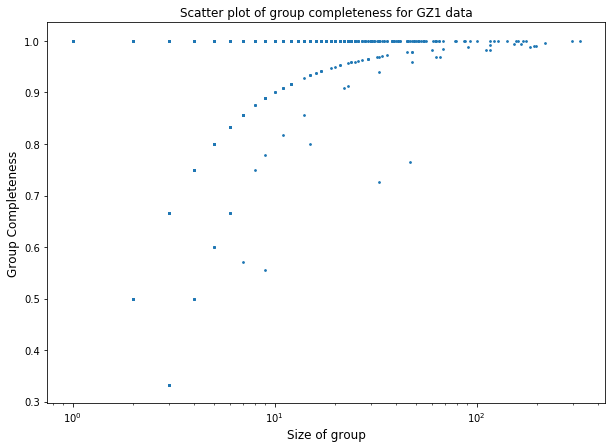

In [13]:
# Create a new column with the fractional completeness of the group
volume_limited_groups["group_completeness"] = volume_limited_groups["GZ_galaxies_in_group"] / volume_limited_groups["volume_limited_galaxies_in_group"]

# Create a pandas dataframe and group data by size of groups,
# calculating the average completeness for groups greater than a cetain size
groups_unique = volume_limited_groups.drop_duplicates(subset=["group_id_new"], keep="first")  # Only keep 1 row for each group
groups_3_completeness = groups_unique[groups_unique["volume_limited_galaxies_in_group"] >= 3]["group_completeness"].mean()
groups_10_completeness = groups_unique[groups_unique["volume_limited_galaxies_in_group"] >= 10]["group_completeness"].mean()
groups_30_completeness = groups_unique[groups_unique["volume_limited_galaxies_in_group"] >= 30]["group_completeness"].mean()
print("Average completeness of groups N>=3: " + str(np.round(groups_3_completeness, decimals=3)))
print("Average completeness of groups N>=10: " + str(np.round(groups_10_completeness, decimals=3)))
print("Average completeness of groups N>=30: " + str(np.round(groups_30_completeness, decimals=3)))

# Plot a scatter plot of group completeness for all groups in the volume limit
plt.figure(figsize=(10,7))
plt.scatter(groups_unique["volume_limited_galaxies_in_group"], groups_unique["group_completeness"], s=3)
plt.xscale("log")
plt.xlabel("Size of group", fontsize=12)
plt.ylabel("Group Completeness", fontsize=12)
plt.title("Scatter plot of group completeness for GZ1 data", fontsize=12)
plt.show()

On average, groups with $N \geq 3$ have an average group completeness of 0.981, and groups with $N \geq 10$ have an average group completeness of 0.99. We therefore have Galaxy Zoo data on almost all of the galaxies in the volume limit, so we can be sure we know about each group in detail.

For small group sizes there are some groups which have a low group completeness (as missing 1 galaxy from the group significantly reduces the completeness). This can be seen by the general upward trend in completeness at larger group sizes.

The high group completeness for means that we can be confident we are sampling a good amount of data to draw conclusions from our analysis of the volume limited groups using GZ data.

## The merger fraction
Now that we have our volume limited sample, we can calculate the merger fraction as functions of variables in our data. First we will calculate the merger fraction against group size.

In [14]:
volume_limited_data = volume_limited_groups.copy()

### Merger fraction and group size
We will now look at how the merger fraction $f_m$ (the fraction of galaxies that are undergoing mergers) changes with group size for our volume limited sample.

Our hypothesis is that at low group sizes the merger fraction will be small, as it is unlikely that, for example, in a group size of 2 that the galaxies are merging. We also expect that for large group sizes the merger fraction will be small, as the energy in larger groups is much higher, meaning the galaxies have greater velocities and therefore will be more likely to fly-by other galaxiess rather than become gravitationally bound and merge, unless it is a head on collision.

For our mergers, we will use the 2,059 galaxies that are classified in either GZ1 or GZ2, and we will calculate the merger fraction against the 44,418 groups in the volume limited sample, which contain 67,478 galaxies (Note that we only have classification data from GZ1 or GZ2 on 67,044 galaxies).

First we create logarithmically spaced bins that have an (approximately) equal number of galaxies in each bin.

To attempt to estimate the error on our merger fraction, we will boostrap the data. For each iteration, we will choose a random sample of our 67,478 galaxies and recalculate the merger fraction using the same bins. This has been done 1000 times, and the minimum and maximum merger fraction at each point will be taken and used to fill between on our plot. A red horizontal line is also added at the value of the merger fraction for $N=1$ groups. This is the "field value", for lone galaxies.

Bins without small groups: [  3   4  12  48 324]
Bins with small groups: [  1   2   3   4  12  48 324]


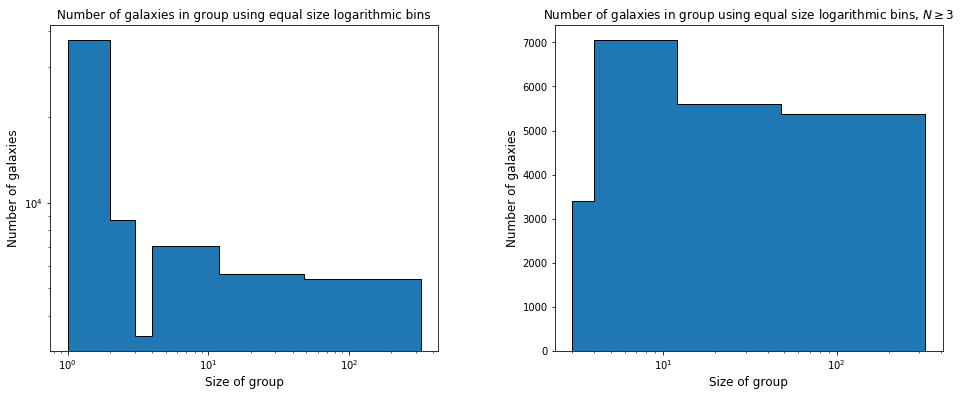

Bootstrapping minimum: [0.01236586 0.06330404 0.0664267  0.04860344 0.03397866 0.03141145]
Bootstrapping maximum: [0.01353156 0.06919443 0.07503277 0.05380598 0.03899446 0.036853  ]


,Average group size of bin,Merger fraction $f_m$,Galaxies in bin
0,1.000000,0.012947,37383
1,2.000000,0.066782,8670
2,3.000000,0.071197,3399
3,6.259722,0.051519,7046
4,25.042523,0.036627,5597
5,128.876655,0.034553,5383


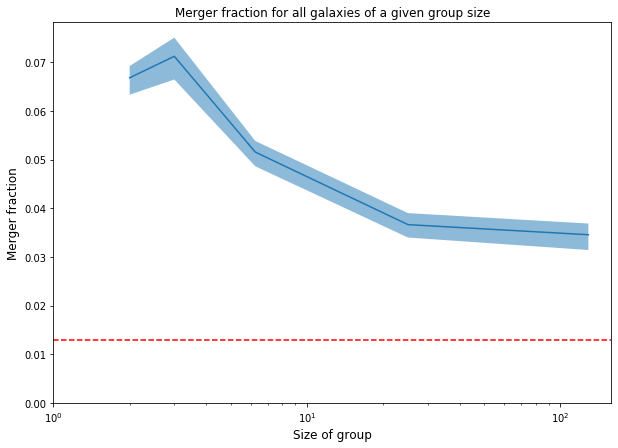

In [15]:
# Create logarithmic bins of equal size without small groups
group_size = volume_limited_data["volume_limited_galaxies_in_group"]
equal_log_bins = pd.qcut(x=np.log10(group_size[group_size > 2]), q=4, labels=False, retbins=True, duplicates="drop")[1]
equal_log_bins = np.power(10, equal_log_bins)
equal_log_bins = np.round(equal_log_bins, 0)

# Add small groups back into new bins
equal_log_bins_with_small = np.insert(equal_log_bins, [0], 1)
equal_log_bins_with_small = np.insert(equal_log_bins_with_small, [1], 2)

# Print the bins that have been calculated
print("Bins without small groups: " + str(equal_log_bins.astype(int)))
print("Bins with small groups: " + str(equal_log_bins_with_small.astype(int)))

fig, ax = plt.subplots(1, 2, figsize=(16,6))

# Plot histogram of group size using logarithmic bins
ax[0].hist(group_size, bins=equal_log_bins_with_small, edgecolor="black", histtype="stepfilled")
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].set_xlabel("Size of group", fontsize=12)
ax[0].set_ylabel("Number of galaxies", fontsize=12)
ax[0].set_title("Number of galaxies in group using equal size logarithmic bins", fontsize=12)

# Plot histogram of group size using logarithmic bins for N >= 3
ax[1].hist(group_size, bins=equal_log_bins, edgecolor="black", histtype="stepfilled")
ax[1].set_xscale("log")
# ax[1].set_yscale("log")
ax[1].set_xlabel("Size of group", fontsize=12)
ax[1].set_ylabel("Number of galaxies", fontsize=12)
ax[1].set_title("Number of galaxies in group using equal size logarithmic bins, $N \geq 3$", fontsize=12)

fig.subplots_adjust(wspace=0.3)

plt.show()

def merger_fraction_group_size_bootstrapping(limited_data, group_size_bins, iterations, bootstrapping_fraction):
    """For each iteration (the number given by "iterations") takes a random sample of the data
    (the fraction given by "bootstrapping_fraction") and calculates the merger fraction
    using the bins provided. Returns an array of size (iterations x number of points)
    containing every merger fraction calculated."""
    
    # Resample table with only the data needed to speed up processing
    limited_data = limited_data[["volume_limited_galaxies_in_group", "Merger_classifications"]]
    
    # Calculate number of points for plotting
    number_of_points = len(group_size_bins) - 1
    
    #Calculate the size of each sample to calculate merger fraction with
    number_for_boostrapping = int(bootstrapping_fraction * len(limited_data))
    
    # Create numpy array to store merger fraction calculations in
    merger_fractions = np.zeros((iterations, number_of_points))
    
    # Loop to calculate merger fraction
    for x in range(iterations):
        # Generate new sample of the data
        data_sampled = limited_data.sample(number_for_boostrapping)
        
        # Bin data by group size, with the bin sizes specified
        allbinned, bin_edges = np.histogram(data_sampled["volume_limited_galaxies_in_group"], bins=group_size_bins)
        mergersbinned, bin_edges = np.histogram(data_sampled[data_sampled["Merger_classifications"] > 0]["volume_limited_galaxies_in_group"], bins=group_size_bins)
    
        allbinned = allbinned.astype(float)
        mergersbinned = mergersbinned.astype(float)
    
        # Find merger fraction and add to numpy array of all merger fractions
        merger_fractions[x] = mergersbinned / allbinned
        
    return merger_fractions

# Call function with all_data and calculated logarithmic bins
merger_fraction_group_size_bootstrapped = merger_fraction_group_size_bootstrapping(volume_limited_data, equal_log_bins_with_small, iterations=1000, bootstrapping_fraction=0.9)
merger_fraction_group_size_bootstrapped_min = np.amin(merger_fraction_group_size_bootstrapped, axis=0) # Find minimum of each point
merger_fraction_group_size_bootstrapped_max = np.amax(merger_fraction_group_size_bootstrapped, axis=0) # Find maximum of each point

# Print minimum and maximum merger fractions of each point
print("Bootstrapping minimum: " + str(merger_fraction_group_size_bootstrapped_min))
print("Bootstrapping maximum: " + str(merger_fraction_group_size_bootstrapped_max))

# Define a function that given some data, will return the merger fraction against redshift
def merger_fraction_group_size_binning(limited_data, group_size_bins):
    """Takes data, picks out mergers and calculates the merger fraction using
    the bins provided. Returns an array of merger fraction against group size,
    the average group size of galaxies in bin for plotting and the number
    of galaxies in each bin."""
    
    # Resample table with only the data needed
    limited_data = limited_data[["volume_limited_galaxies_in_group", "Merger_classifications"]]
    
    # Bin data by group size, with the bin sizes specified
    allbinned, bin_edges = np.histogram(limited_data["volume_limited_galaxies_in_group"], bins=group_size_bins)
    mergersbinned, bin_edges = np.histogram(limited_data[limited_data["Merger_classifications"] > 0]["volume_limited_galaxies_in_group"], bins=group_size_bins)
    
    # Calculate the average group size in each bin for plotting data
    bin_centres=[]
    for i in range(len(bin_edges) - 1):
        bin_centres.append(limited_data[(limited_data["volume_limited_galaxies_in_group"] >= bin_edges[i]) & (limited_data["volume_limited_galaxies_in_group"] < bin_edges[i + 1])]["volume_limited_galaxies_in_group"].mean())
    
    allbinned = allbinned.astype(float)
    mergersbinned = mergersbinned.astype(float)
    
    # Find merger fraction
    merger_fraction_group = mergersbinned / allbinned
    
    return merger_fraction_group, bin_centres, allbinned.astype(int)

# Call function with all_data and calculated logarithmic bins
merger_fraction_groups, group_size_bin_centres, galaxies_in_bin = merger_fraction_group_size_binning(volume_limited_data, equal_log_bins_with_small)

# Create dataframe of average group size, merger fraction and gaalxies in each bin and display it
merger_fraction_groups_info = list(zip(group_size_bin_centres, merger_fraction_groups, galaxies_in_bin))
display(pd.DataFrame(merger_fraction_groups_info, columns=["Average group size of bin", "Merger fraction $f_m$", "Galaxies in bin"]))

# Plot a line plot of merger fraction with the minimum and maximum from bootstrapping filled in
plt.figure(figsize=(10,7))
plt.plot(group_size_bin_centres[1:], merger_fraction_groups[1:])
plt.fill_between(group_size_bin_centres[1:], merger_fraction_group_size_bootstrapped_min[1:], merger_fraction_group_size_bootstrapped_max[1:], alpha=0.5)
plt.axhline(y=merger_fraction_groups[0], linestyle="--", c="red")
plt.xscale("log")
plt.xlim(left=1)
plt.ylim(bottom=0)
plt.xlabel("Size of group", fontsize=12)
plt.ylabel("Merger fraction", fontsize=12)
plt.title("Merger fraction for all galaxies of a given group size", fontsize=12)
plt.show()

As we can see from the plot, the error calculated from bootstrapping is fairly small. We can be confident that our merger fraction is showing a true relation, and is not due to picking certain data or not.

The field value for the merger fraction is the lowest value of the merger fraction at $\sim 0.013$ for the bin $N=1$. The merger fraction then raises to a peak of $\sim 0.071$ at a group size of $N=3$. The merger fraction then falls as the group size increases, to $\sim 0.035$ for the bin with $N_\text{avg} = 128.9$.

This graph supports our hypothesis that for larger group sizes the merger fraction will decrease.

### Merger fraction and redshift

Due to the small range in redshift of our volume limited sample ($ 0.01 < z_\text{mean} < 0.05$), we should not expect the merger fraction to change very much over this range.

Ther merger fraction is generally parameterised as $f_m = f_m(0) (1+z)^m$, where m is the merger index (typically $m$ is in the range $\sim 0 - 4$). Because the redshift $z$ only changes from $z=0.01$ to $z=0.05$, this would not increase the value of $f_m$ from this expression by much. Therefore we should expect our plot of merger fracation against redshift to be fairly constant over our redshift range.

Redshift bins: [0.00988751 0.02766508 0.03357749 0.03862419 0.04314015 0.04657659
 0.05523933]


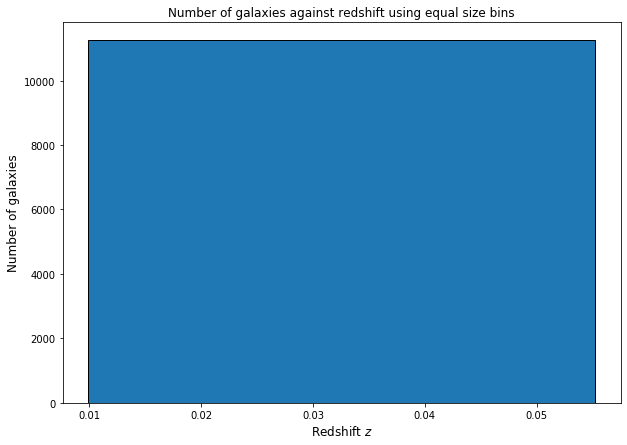

Bootstrapping minimum: [0.03163618 0.03205319 0.02924034 0.02906118 0.02641772 0.02479012]
Bootstrapping maximum: [0.03516397 0.03560418 0.0325623  0.03271721 0.0295811  0.02760736]


,Average redshift of bin,Merger fraction $f_m$,Galaxies in bin
0,0.022373,0.033520,11247
1,0.030787,0.033701,11246
2,0.036107,0.030944,11246
3,0.041022,0.030678,11246
4,0.044957,0.028010,11246
5,0.048288,0.026229,11247


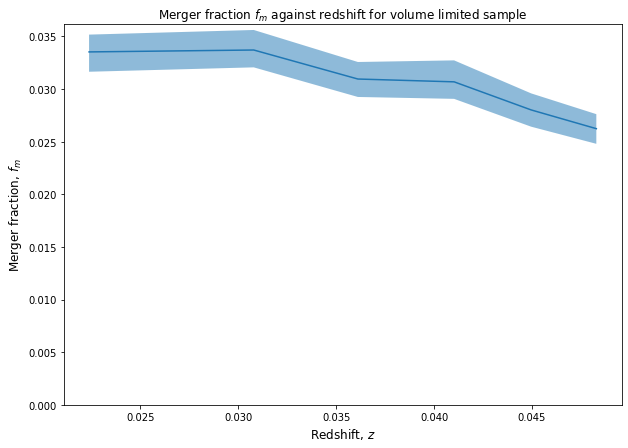

In [16]:
# Create logarithmic bins of equal size without small groups
redshifts = volume_limited_data["Best_redshift_new"]
redshift_equal_bins = pd.qcut(redshifts, q=6, labels=False, retbins=True, duplicates="drop")[1]

# Print the bins that have been calculated
print("Redshift bins: " + str(redshift_equal_bins))

# Plot histogram of redshift using equal bins
plt.figure(figsize=(10,7))
plt.hist(redshifts, bins=redshift_equal_bins, edgecolor="black", histtype="stepfilled")
plt.xlabel("Redshift $z$", fontsize=12)
plt.ylabel("Number of galaxies", fontsize=12)
plt.title("Number of galaxies against redshift using equal size bins", fontsize=12)
plt.show()

def merger_fraction_redshift_bootstrapping(limited_data, redshift_bins, iterations, bootstrapping_fraction):
    """For each iteration (the number given by "iterations") takes a random sample of the data
    (the fraction given by "bootstrapping_fraction") and calculates the merger fraction
    using the bins provided. Returns an array of size (iterations x number of points)
    containing every merger fraction calculated."""
    
    # Resample table with only the data needed to speed up processing
    limited_data = limited_data[["Best_redshift_new", "Merger_classifications"]]
    
    # Calculate number of points for plotting
    number_of_points = len(redshift_bins) - 1
    
    #Calculate the size of each sample to calculate merger fraction with
    number_for_boostrapping = int(bootstrapping_fraction * len(limited_data))
    
    # Create numpy array to store merger fraction calculations in
    merger_fractions = np.zeros((iterations, number_of_points))
    
    # Loop to calculate merger fraction
    for x in range(iterations):
        # Generate new sample of the data
        data_sampled = limited_data.sample(number_for_boostrapping)
        
        # Bin data by group size, with the bin sizes specified
        allbinned, bin_edges = np.histogram(data_sampled["Best_redshift_new"], bins=redshift_bins)
        mergersbinned, bin_edges = np.histogram(data_sampled[data_sampled["Merger_classifications"] > 0]["Best_redshift_new"], bins=redshift_bins)
    
        allbinned = allbinned.astype(float)
        mergersbinned = mergersbinned.astype(float)
    
        # Find merger fraction and add to numpy array of all merger fractions
        merger_fractions[x] = mergersbinned / allbinned
        
    return merger_fractions

# Call function with all_data and calculated logarithmic bins
merger_fraction_redshift_bootstrapped = merger_fraction_redshift_bootstrapping(volume_limited_data, redshift_equal_bins, iterations=1000, bootstrapping_fraction=0.9)
merger_fraction_redshift_bootstrapped_min = np.amin(merger_fraction_redshift_bootstrapped, axis=0) # Find minimum of each point
merger_fraction_redshift_bootstrapped_max = np.amax(merger_fraction_redshift_bootstrapped, axis=0) # Find maximum of each point

# Print minimum and maximum merger fractions of each point
print("Bootstrapping minimum: " + str(merger_fraction_redshift_bootstrapped_min))
print("Bootstrapping maximum: " + str(merger_fraction_redshift_bootstrapped_max))

# Define a function that given some data, will return the merger fraction against redshift
def merger_fraction_redshift_binning(limited_data, redshift_bins):
    """Takes data, picks out mergers and calculates the merger fraction using
    the bins provided. Returns an array of merger fraction against group size,
    the average group size of galaxies in bin for plotting and the number
    of galaxies in each bin."""
    
    # Resample table with only the data needed
    limited_data = limited_data[["Best_redshift_new", "Merger_classifications"]]
    
    # Bin data by group size, with the bin sizes specified
    allbinned, bin_edges = np.histogram(limited_data["Best_redshift_new"], bins=redshift_bins)
    mergersbinned, bin_edges = np.histogram(limited_data[limited_data["Merger_classifications"] > 0]["Best_redshift_new"], bins=redshift_bins)
    
    # Calculate the average group size in each bin for plotting data
    bin_centres=[]
    for i in range(len(bin_edges) - 1):
        bin_centres.append(limited_data[(limited_data["Best_redshift_new"] >= bin_edges[i]) & (limited_data["Best_redshift_new"] < bin_edges[i + 1])]["Best_redshift_new"].mean())
    
    allbinned = allbinned.astype(float)
    mergersbinned = mergersbinned.astype(float)
    
    # Find merger fraction
    merger_fraction_redshift = mergersbinned / allbinned
    
    return merger_fraction_redshift, bin_centres, allbinned.astype(int)

# Call function with all_data and calculated logarithmic bins
merger_fraction_redshift, redshift_bin_centres, galaxies_in_bin = merger_fraction_redshift_binning(volume_limited_data, redshift_equal_bins)

# Create dataframe of average group size, merger fraction and gaalxies in each bin and display it
merger_fraction_redshift_info = list(zip(redshift_bin_centres, merger_fraction_redshift, galaxies_in_bin))
display(pd.DataFrame(merger_fraction_redshift_info, columns=["Average redshift of bin", "Merger fraction $f_m$", "Galaxies in bin"]))

# Plot a line plot of merger fraction with the minimum and maximum from bootstrapping filled in
plt.figure(figsize=(10,7))
plt.plot(redshift_bin_centres, merger_fraction_redshift)
plt.fill_between(redshift_bin_centres, merger_fraction_redshift_bootstrapped_min, merger_fraction_redshift_bootstrapped_max, alpha=0.5)
plt.ylim(bottom=0)
plt.xlabel("Redshift, $z$", fontsize=12)
plt.ylabel("Merger fraction, $f_m$", fontsize=12)
plt.title("Merger fraction $f_m$ against redshift for volume limited sample", fontsize=12)
plt.show()

As expected, the merger fraction does not change much with redshift, possibly showing a small decrease but the bootstrapping errors almost account for this change.

We could do a statistical test on the line of merger fraction against redshift to see if there is a significant change or whether it is constant.

### The merger fraction and velocities

#### Calculating velocities
We calculate the proper velocities $v_i$ of a galaxy $i$ within a group as is done in [Danese et al. (1980)](http://articles.adsabs.harvard.edu/pdf/1980A%26A....82..322D):
$$v_i = c \cdot \frac{z_i - z_\text{group}}{1+z_\text{group}}$$
where $z_i$ is the redshift of a galaxy $i$ and $z_\text{group}$ is the mean redshift of all the members of a group. The velocity dispersion of a group can then be calculated using
$$\sigma = \sqrt{\frac{1}{N_\text{group}-1}\sum_{i=1}^{N_\text{group}}(v_i - \left< v_i \right>)^2}$$
We do this for our sample of galaxies below. Note that by using our definition of $v_i$, $\left< v_i \right> = 0$ since $\sum_{i=1}^{N_\text{group}}(z_i - z_\text{group}) = 0$ by definition.

These velocities have already been calculated for our volume limited groups, so we import them below and match them to our volume limited data.

We have previously decided that we are only interested in groups of size $N \geq 3$. This gives us data on 21,425 galaxies within 2,700 groups.

In [17]:
# Create copy of data with only groups N >= 3
volume_limited_groups_larger_than_1 = volume_limited_data[volume_limited_data["volume_limited_galaxies_in_group"] >= 3]

# Print number of galaxies and number of groups remaining
print("Number of groups with size 3 or greater: " + str(len(np.unique(volume_limited_groups_larger_than_1["group_id_new"]))))
print("Number of galaxies in groups with size 3 or greater: " + str(len(volume_limited_groups_larger_than_1)))

Number of groups with size 3 or greater: 2700
Number of galaxies in groups with size 3 or greater: 21425


In [18]:
# # Select only needed columns
# groups_data_needed = volume_limited_groups_larger_than_1[["galaxy ID", "group_id_new", "volume_limited_galaxies_in_group", "Best_redshift_new", "z_group_mean"]].copy()
# # Reset index of table
# groups_data_needed.reset_index(inplace=True, drop=True)
# # Groupby galaxy group id, creating a dictrionary with group id as the key, and the indicies of the galaxies as values
# groups = groups_data_needed.groupby("group_id_new").indices

# # Add the new desired columns to the DataFrame
# groups_data_needed["v_i"] = 0
# groups_data_needed["velocity_dispersion"] = 0

# # Print the number of groups the calculation must be done for
# print("Number of groups to calculate for: " + str(len(groups)))
# i = 1

# for key, values in groups.items(): # Iterate over the dictionary of group ids
#     # Get group size and mean redshift of group
#     group_size = groups_data_needed.loc[values[0], "volume_limited_galaxies_in_group"]
#     z_mean = groups_data_needed.loc[values[0], "z_group_mean"]

#     # Calculate the individual galaxy velocities for all galaxies in the group
#     groups_data_needed.loc[values, "v_i"] = (groups_data_needed.loc[values, "Best_redshift_new"] - z_mean) / (1 + z_mean) * 299792458
    
#     # Calculate the velocity dispersion of the group
#     groups_data_needed.loc[values, "velocity_dispersion"] = (1/(group_size-1) * ((groups_data_needed.loc[values, "v_i"])**2).sum())**(1/2)
    
#     # Progress checker
#     if i % 5000 == 0:
#         print("Progress: " + str(i) + " groups done")
#     elif i == len(groups):
#         print("Progress: Done")
#     i += 1


# # Change velocities to km/s
# groups_data_needed["v_i"] = groups_data_needed["v_i"] / 1000
# groups_data_needed["velocity_dispersion"] = groups_data_needed["velocity_dispersion"] / 1000

In [19]:
# # Create astropy table of velocity data to save
# volume_limited_velocity_data_pandas = groups_data_needed[["galaxy ID", "v_i", "v_i_absolute", "velocity_dispersion"]].copy()
# volume_limited_velocity_data = Table.from_pandas(volume_limited_velocity_data_pandas)

# # Save velocity data
# volume_limited_velocity_data.write("E:\\MPhys Project\\Main Data\\velocity_data_volume_limited.fits")

In [20]:
# Read previously calculated mean z for volume limited groups
velocities_filename = "E:\\MPhys Project\\Main Data\\velocity_data_volume_limited.fits"

with fits.open(velocities_filename) as data:
    velocity_data_to_merge = Table(data[1].data)

# Crate pandas DataFrames to merge
velocity_data_to_merge_pandas = velocity_data_to_merge.to_pandas()

# Merge the two DataFrames, keeping all the rows in the full DataFrame
volume_limited_merged = pd.merge(volume_limited_data, velocity_data_to_merge_pandas, on="galaxy ID", how="left")

# Display head of data
display(volume_limited_merged.head())

# Turn DataFrame back into astropy table
volume_limited_data = volume_limited_merged.copy()

,galaxy ID,NYU-VAGC ID object ID,ra_galaxy,dec_galaxy,z_galaxy,apparent magnitude r_band,magnitude limit r_band,completeness,col9 Petro,col10 Petro,...,Merger_classifications,z_group_mean,volume_limited_sample,volume_limited_galaxies_in_group,GZ,GZ_galaxies_in_group,group_completeness,v_i,v_i_absolute,velocity_dispersion
0,15,1071,55.263436,0.474025,0.020532,15.612914,17.620001,0.990148,-18.457977,0.424444,...,0,0.020532,1,1,1,1,1.0,NaN,NaN,NaN
1,18,1106,55.684450,0.551383,0.039925,17.044107,17.620001,0.990148,-18.389984,0.423232,...,0,0.039925,1,1,1,1,1.0,NaN,NaN,NaN
2,19,1122,55.989529,0.437805,0.039970,14.945643,17.620001,0.990148,-20.530043,0.911639,...,0,0.039970,1,1,1,1,1.0,NaN,NaN,NaN
3,23,1128,55.968565,0.614348,0.040589,14.131188,17.620001,0.990148,-21.302609,0.649221,...,0,0.040645,1,2,1,2,1.0,-16.111055,16.111055,22.784472
4,24,1130,55.977487,0.459108,0.037089,15.813791,17.620001,0.990148,-19.450733,0.421843,...,0,0.037090,1,1,1,1,1.0,NaN,NaN,NaN


Now that we have imported the velocities and velocity dispersions for the galaxies and groups in our data set, we want to see how the merger fraction $f_m$ changes with these parameters.

We first bin the data such that there are an equal number of galaxies or groups in each bin, for the velocities and the velocity dispersion. We plot a histogram of the binned data to check that there are indeed an equal number in each bin.

Velocity bins: [   0.           16.24068656   33.98098146   54.66488042   78.93113984
  109.73630843  152.51181547  212.78891047  310.33507458  485.26817798
 2476.61985834]
Velocity dispersion bins: [   0.           52.62773254   84.82194896  118.83386113  155.88227331
  206.53619751  258.48681946  318.18677575  408.0545718   527.04873438
 1542.2534056 ]


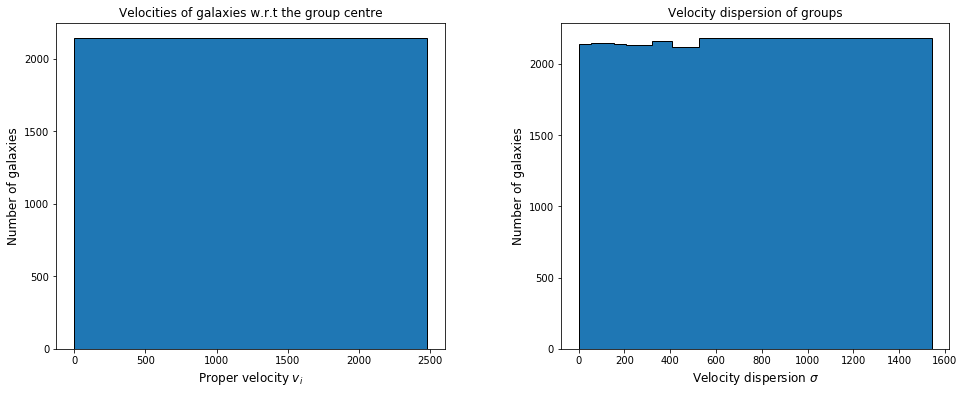

In [21]:
# Create bins of equal size for velocities
velocity_data = volume_limited_data[volume_limited_data["volume_limited_galaxies_in_group"] >= 3].copy()

velocity_equal_bins = pd.qcut(x=velocity_data["v_i_absolute"], q=10, labels=False, retbins=True, duplicates="drop")[1]

velocity_dispersion_equal_bins = pd.qcut(x=velocity_data["velocity_dispersion"], q=10, labels=False, retbins=True, duplicates="drop")[1]

# velocity_equal_log_bins = pd.qcut(x=np.log10(velocity_data["v_i"]), q=10, labels=False, retbins=True, duplicates="drop")[1]
# velocity_equal_log_bins = np.power(10, equal_log_bins)

# velocity_dispersion_log_bins = pd.qcut(x=np.log10(velocity_data["velocity_dispersion"]), q=10, labels=False, retbins=True, duplicates="drop")[1]
# velocity_dispersion_equal_log_bins = np.power(10, equal_log_bins)

# Print the bins that have been calculated
print("Velocity bins: " + str(velocity_equal_bins))
print("Velocity dispersion bins: " + str(velocity_dispersion_equal_bins))

fig, ax = plt.subplots(1, 2, figsize=(16,6))

# Plot histogram of velocity using velocity bins
ax[0].hist(velocity_data["v_i_absolute"], bins=velocity_equal_bins, edgecolor="black", histtype="stepfilled")
#ax[0].set_xscale("log")
#ax[0].set_yscale("log")
ax[0].set_xlabel("Proper velocity $v_i$", fontsize=12)
ax[0].set_ylabel("Number of galaxies", fontsize=12)
ax[0].set_title("Velocities of galaxies w.r.t the group centre", fontsize=12)

# Plot histogram of velocity dispersion using velocity dispersion bins
ax[1].hist(velocity_data["velocity_dispersion"], bins=velocity_dispersion_equal_bins, edgecolor="black", histtype="stepfilled")
#ax[1].set_xscale("log")
#ax[1].set_yscale("log")
ax[1].set_xlabel("Velocity dispersion $\sigma$", fontsize=12)
ax[1].set_ylabel("Number of galaxies", fontsize=12)
ax[1].set_title("Velocity dispersion of groups", fontsize=12)

fig.subplots_adjust(wspace=0.3)

plt.show()


### Galaxy velocities
We first calculate the merger fraction of the individual galaxy velocities. To attempt to estimate the error on our merger fraction, we will boostrap the data. For each iteration, we will choose a random sample of our 21,425 galaxies with velocity data and recalculate the merger fraction using the same bins. This has been done 1000 times, and the minimum and maximum merger fraction at each point will be taken and used to fill between on our plot.

Bootstrapping velocity minimum: [0.06013478 0.05235874 0.04033092 0.04399586 0.0378748  0.04082687
 0.0392562  0.03079332 0.02327988 0.0426861 ]
Bootstrapping velocity maximum: [0.07135471 0.0628866  0.04903495 0.05339554 0.04731861 0.049922
 0.05046826 0.03987408 0.03016121 0.05197505]


,Average galaxy velocity in bin,Merger fraction $f_m$,Galaxies in bin
0,7.432863,0.066729,2143
1,24.868448,0.058357,2142
2,44.194863,0.045285,2142
3,66.349374,0.048997,2143
4,93.631988,0.043417,2142
5,129.727173,0.045730,2143
6,180.259224,0.045752,2142
7,257.257320,0.035931,2143
8,388.394811,0.027077,2142
9,745.500967,0.047597,2143


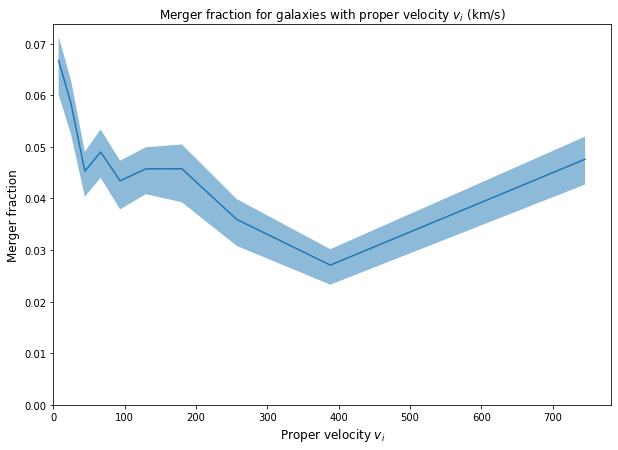

In [22]:
def merger_fraction_velocity_bootstrapping(data, velocity_bins, iterations, bootstrapping_fraction):
    """For each iteration (the number given by "iterations") takes a random sample of the data
    (the fraction given by "bootstrapping_fraction") and calculates the merger fraction
    using the bins provided. Returns an array of size (iterations x number of points)
    containing every merger fraction calculated."""
    
    # Resample table with only the data needed to speed up processing
    data = data[["v_i_absolute", "Merger_classifications"]].copy()
    
    # Calculate number of points for plotting
    number_of_points = len(velocity_bins) - 1
    
    # Calculate the size of each sample to calculate merger fraction with
    number_for_boostrapping = int(bootstrapping_fraction * len(data))
    
    # Create numpy array to store merger fraction calculations in
    merger_fractions = np.zeros((iterations, number_of_points))
    
    # Loop to calculate merger fraction
    for x in range(iterations):
        # Generate new sample of the data
        data_sampled = data.sample(number_for_boostrapping)
        
        # Bin data by velocities, with the bin sizes specified
        allbinned, bin_edges = np.histogram(data_sampled["v_i_absolute"], bins=velocity_bins)
        mergersbinned, bin_edges = np.histogram(data_sampled[data_sampled["Merger_classifications"] > 0]["v_i_absolute"], bins=velocity_bins)
    
        allbinned = allbinned.astype(float)
        mergersbinned = mergersbinned.astype(float)
    
        # Find merger fraction and add to numpy array of all merger fractions
        merger_fractions[x] = mergersbinned / allbinned
        
    return merger_fractions

# Call function with all_data and calculated velocity bins
velocity_data_pandas = velocity_data.copy()
merger_fraction_velocity_bootstrapped = merger_fraction_velocity_bootstrapping(velocity_data_pandas, velocity_equal_bins, iterations=1000, bootstrapping_fraction=0.9)
merger_fraction_velocity_bootstrapped_min = np.amin(merger_fraction_velocity_bootstrapped, axis=0) # Find minimum of each point
merger_fraction_velocity_bootstrapped_max = np.amax(merger_fraction_velocity_bootstrapped, axis=0) # Find maximum of each point

# Print minimum and maximum merger fractions of each point
print("Bootstrapping velocity minimum: " + str(merger_fraction_velocity_bootstrapped_min))
print("Bootstrapping velocity maximum: " + str(merger_fraction_velocity_bootstrapped_max))

# Define a function that given some data, will return the merger fraction against galaxy velocities
def merger_fraction_velocity_binning(data, velocity_bins):
    """Takes data, picks out mergers and calculates the merger fraction using
    the bins provided. Returns an array of merger fraction against galaxy velocities,
    the average velocity of galaxies in bin for plotting and the number
    of galaxies in each bin."""
    
    # Resample table with only the data needed
    data = data[["v_i_absolute", "Merger_classifications"]]
    
    # Bin data by velocity, with the bin sizes specified
    allbinned, bin_edges = np.histogram(data["v_i_absolute"], bins=velocity_bins)
    mergersbinned, bin_edges = np.histogram(data[data["Merger_classifications"] > 0]["v_i_absolute"], bins=velocity_bins)
    
    # Calculate the average velocity in each bin for plotting data
    bin_centres=[]
    for i in range(len(bin_edges) - 1):
        bin_centres.append(data[(data["v_i_absolute"] >= bin_edges[i]) & (data["v_i_absolute"] < bin_edges[i + 1])]["v_i_absolute"].mean())
    
    allbinned = allbinned.astype(float)
    mergersbinned = mergersbinned.astype(float)
    
    # Find merger fraction
    merger_fraction_group = mergersbinned / allbinned
    
    return merger_fraction_group, bin_centres, allbinned.astype(int)

# Call function with all_data and calculated velocity bins
merger_fraction_velocities, velocity_bin_centres, galaxies_in_bin = merger_fraction_velocity_binning(velocity_data_pandas, velocity_equal_bins)

# Create dataframe of average galaxy velocity, merger fraction and gaalxies in each bin and display it
merger_fraction_velocity_info = list(zip(velocity_bin_centres, merger_fraction_velocities, galaxies_in_bin))
display(pd.DataFrame(merger_fraction_velocity_info, columns=["Average galaxy velocity in bin", "Merger fraction $f_m$", "Galaxies in bin"]))

# Plot a line plot of merger fraction with the minimum and maximum from bootstrapping filled in
plt.figure(figsize=(10,7))
plt.plot(velocity_bin_centres, merger_fraction_velocities)
plt.fill_between(velocity_bin_centres, merger_fraction_velocity_bootstrapped_min, merger_fraction_velocity_bootstrapped_max, alpha=0.5)
#plt.xscale("log")
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.xlabel("Proper velocity $v_i$", fontsize=12)
plt.ylabel("Merger fraction", fontsize=12)
plt.title("Merger fraction for galaxies with proper velocity $v_i$ (km/s)", fontsize=12)
plt.show()

There is a large peak in the merger fraction in the first bin of $\sim 0.067 \%$, before it generally decreases towards higher velocities. The merger fraction increases again in the final velocity bin. However this is possibly due to some galaxies in a group having significantly different new redshifts, causing the velocity to be artificially inflated.

We should inspect galaxies in groups with high velocities or that have significantly different redshifts from the mean redshift of the group to test this.

### Group velocity dispersion
We now calculate the merger fraction against group velocity dispersion velocities. We again perform a bootstrapping procedure in order to estimate the error on the merger fraction.

Bootstrapping velocity dispersion minimum: [0.07049608 0.05219638 0.04446743 0.04826155 0.0526047  0.03144654
 0.0265902  0.02119959 0.02528978 0.03967447]
Bootstrapping velocity dispersion maximum: [0.08125    0.06325144 0.05509356 0.05854922 0.06282451 0.03888025
 0.03451883 0.02911134 0.03315789 0.04854369]


,Average group velocity dispersion in bin,Merger fraction $f_m$,Galaxies in bin,Groups in bin
0,30.351563,0.076600,2141,639
1,68.466909,0.058357,2142,549
2,101.159701,0.050350,2145,478
3,136.416268,0.053221,2142,376
4,181.185792,0.058466,2138,270
5,232.997245,0.035614,2134,178
6,282.745118,0.031426,2132,106
7,358.744250,0.026413,2158,56
8,470.275911,0.029801,2114,28
9,609.329520,0.044516,2179,20


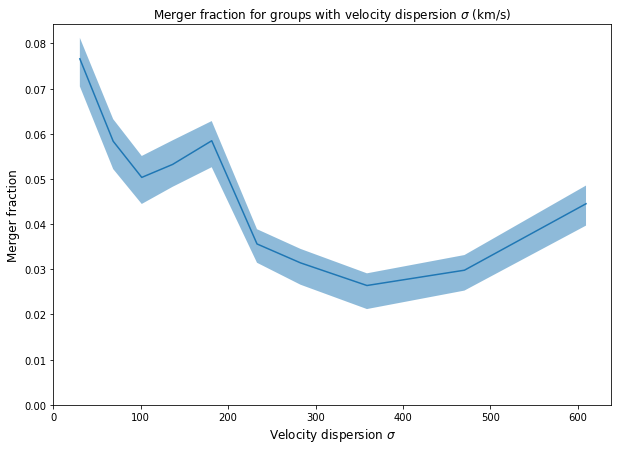

In [23]:
def merger_fraction_velocity_bootstrapping(data, velocity_bins, iterations, bootstrapping_fraction):
    """For each iteration (the number given by "iterations") takes a random sample of the data
    (the fraction given by "bootstrapping_fraction") and calculates the merger fraction
    using the bins provided. Returns an array of size (iterations x number of points)
    containing every merger fraction calculated."""
    
    # Resample table with only the data needed to speed up processing
    data = data[["velocity_dispersion", "Merger_classifications"]].copy()
    
    # Calculate number of points for plotting
    number_of_points = len(velocity_bins) - 1
    
    #Calculate the size of each sample to calculate merger fraction with
    number_for_boostrapping = int(bootstrapping_fraction * len(data))
    
    # Create numpy array to store merger fraction calculations in
    merger_fractions = np.zeros((iterations, number_of_points))
    
    # Loop to calculate merger fraction
    for x in range(iterations):
        # Generate new sample of the data
        data_sampled = data.sample(number_for_boostrapping)
        
        # Bin data by velocity dispersion, with the bin sizes specified
        allbinned, bin_edges = np.histogram(data_sampled["velocity_dispersion"], bins=velocity_bins)
        mergersbinned, bin_edges = np.histogram(data_sampled[data_sampled["Merger_classifications"] > 0]["velocity_dispersion"], bins=velocity_bins)
    
        allbinned = allbinned.astype(float)
        mergersbinned = mergersbinned.astype(float)
    
        # Find merger fraction and add to numpy array of all merger fractions
        merger_fractions[x] = mergersbinned / allbinned
        
    return merger_fractions

# Call function with all_data and calculated velocity dispersion bins
merger_fraction_velocity_dispersion_bootstrapped = merger_fraction_velocity_bootstrapping(velocity_data_pandas, velocity_dispersion_equal_bins, iterations=1000, bootstrapping_fraction=0.9)
merger_fraction_velocity_dispersion_bootstrapped_min = np.amin(merger_fraction_velocity_dispersion_bootstrapped, axis=0) # Find minimum of each point
merger_fraction_velocity_dispersion_bootstrapped_max = np.amax(merger_fraction_velocity_dispersion_bootstrapped, axis=0) # Find maximum of each point

# Print minimum and maximum merger fractions of each point
print("Bootstrapping velocity dispersion minimum: " + str(merger_fraction_velocity_dispersion_bootstrapped_min))
print("Bootstrapping velocity dispersion maximum: " + str(merger_fraction_velocity_dispersion_bootstrapped_max))

# Define a function that given some data, will return the merger fraction against velocity dispersion
def merger_fraction_velocity_dispersion_binning(data, velocity_bins):
    """Takes data, picks out mergers and calculates the merger fraction using
    the bins provided. Returns an array of merger fraction against galaxy velocity dispersion,
    the average velocity dispersion of galaxies in bin for plotting and the number
    of galaxies and groups in each bin."""
    
    # Resample table with only the data needed
    data = data[["velocity_dispersion", "Merger_classifications", "group_id_new"]].copy()
    
    # Create subset with only one representative per group
    groups_unique = data.drop_duplicates(subset=["group_id_new"], keep="first")
    
    # Bin data by velocity dispersion, with the bin sizes specified
    allbinned, bin_edges = np.histogram(data["velocity_dispersion"], bins=velocity_bins)
    groups_unique_binned, bin_edges = np.histogram(groups_unique["velocity_dispersion"], bins=velocity_bins)
    groupsbinned, bin_edges = np.histogram(data["velocity_dispersion"], bins=velocity_bins)
    mergersbinned, bin_edges = np.histogram(data[data["Merger_classifications"] > 0]["velocity_dispersion"], bins=velocity_bins)
    
    # Calculate the average velocity dispersion in each bin for plotting data
    bin_centres=[]
    for i in range(len(bin_edges) - 1):
        bin_centres.append(data[(data["velocity_dispersion"] >= bin_edges[i]) & (data["velocity_dispersion"] < bin_edges[i + 1])]["velocity_dispersion"].mean())
    
    allbinned = allbinned.astype(float)
    mergersbinned = mergersbinned.astype(float)
    
    # Find merger fraction
    merger_fraction_group = mergersbinned / allbinned
    
    return merger_fraction_group, bin_centres, allbinned.astype(int), groups_unique_binned.astype(int)

# Call function with all_data and calculated velocity dispersion bins
merger_fraction_velocity_dispersion, velocity_dispersion_bin_centres, galaxies_in_bin, groups_in_bin = merger_fraction_velocity_dispersion_binning(velocity_data_pandas, velocity_dispersion_equal_bins)

# Create dataframe of average group size, merger fraction and gaalxies in each bin and display it
merger_fraction_velocity_dispersion_info = list(zip(velocity_dispersion_bin_centres, merger_fraction_velocity_dispersion, galaxies_in_bin, groups_in_bin))
display(pd.DataFrame(merger_fraction_velocity_dispersion_info, columns=["Average group velocity dispersion in bin", "Merger fraction $f_m$", "Galaxies in bin", "Groups in bin"]))

# Plot a line plot of merger fraction with the minimum and maximum from bootstrapping filled in
plt.figure(figsize=(10,7))
plt.plot(velocity_dispersion_bin_centres, merger_fraction_velocity_dispersion)
plt.fill_between(velocity_dispersion_bin_centres, merger_fraction_velocity_dispersion_bootstrapped_min, merger_fraction_velocity_dispersion_bootstrapped_max, alpha=0.5)
#plt.xscale("log")
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.xlabel("Velocity dispersion $\sigma$", fontsize=12)
plt.ylabel("Merger fraction", fontsize=12)
plt.title("Merger fraction for groups with velocity dispersion $\sigma$ (km/s)", fontsize=12)
plt.show()

Again we see a large peak in the first bin at low velocity dispersions. The merger fraction then drops slightly, before rising again, and then falling at higher velocity dispersions. Again there is an increase in the final velocity dispersion bin, possibly due to some galaxies having significantly different redshifts to the mean group redshift.

It is possible the large peak seen at low velocities and velocity dispersions is due to limitations in our redshift data for these groups. If two galaxies are a close pair undergoing a merger, sometimes SDSS cannot get a spectra for both targets, and therefore no spectroscopic redshift. Instead a redshift is obtained from the nearest-neighbour, which will be the galaxy of the merging pair that has a spectra. The two merging galaxies therefore will have the same redshift, and will give velocities and a velocity dispersion of 0 if there are no other galaxies in the group.